## PRICE OPTIMISATION

We have a data for products and prices for 17 months. In this naive (not a full analysis like acomprehensive EDA or train-test split applied) project we tried price optimisation to maximize the profit. We want to see what the algorithm suggests Our variables are:
- **GUS**: the gross unit sold for a particular item. 
- **GUSR**: the gross unit sold revenue for that item.
- **GSTR**: Gross store revenue total.
- **GSQ**: Total unit sold for a given month
- **cost**: the item cost (kept constant in dolar terms)

Analysis Summarry: We used log-log model and random forest for . The ** is the best performing model.
  

---

**1. Import libraries and upload :**

In [30]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize_scalar

In [46]:
#upload data
data=pd.read_excel(r"C:\Users\arica\Desktop\price_with_cost.xlsx")
data.head()
print(data.isna().sum()) #check missing data

ID      0
TIME    0
AP      0
GUS     0
GUSR    0
GSTR    0
GSQ     0
cost    0
dtype: int64


---

**2.Exploratory Data Analysis**:

Based on our main research question,  first we want to see the relationship between variables.

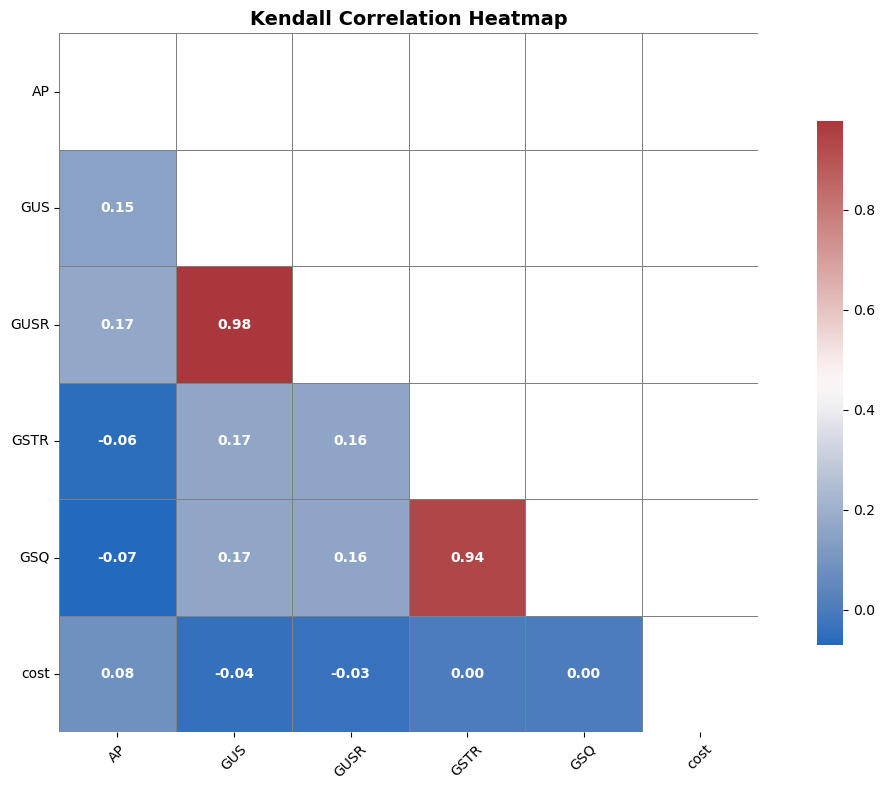

In [16]:
# Select numeric columns and drop ID and TIME
numeric_cols_all = data.select_dtypes(include='number').drop(columns=['ID', 'TIME'], errors='ignore')

# Calculate Kendall correlation matrix
corr_all = numeric_cols_all.corr(method='kendall')

# Generate mask for upper triangle
mask = np.triu(np.ones_like(corr_all, dtype=bool))

# Set figure
plt.figure(figsize=(12, 8))

# Draw heatmap
sns.heatmap(
    corr_all,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="vlag",  # alternatif: "coolwarm", "rocket", "icefire", "mako"
    linewidths=0.7,
    linecolor='gray',
    square=True,
    cbar_kws={"shrink": .75},
    annot_kws={"fontsize": 10, "fontweight": "bold"}
)

plt.title("Kendall Correlation Heatmap", fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Let's see the average price for months:

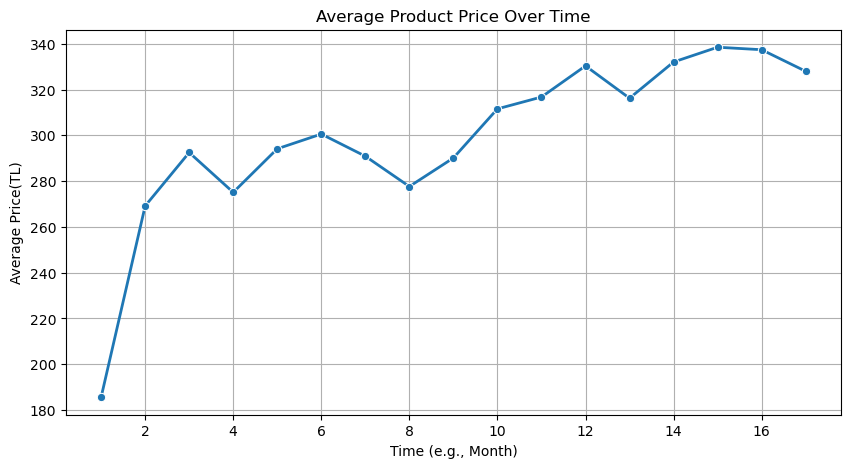

In [18]:
price_over_time = data.groupby('TIME')['AP'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(data=price_over_time, x='TIME', y='AP', marker='o', linewidth=2)
plt.title("Average Product Price Over Time")
plt.xlabel("Time (e.g., Month)")
plt.ylabel("Average Price(TL)")
plt.grid(True)
plt.show()

**2. MODELS:**

*1. Product-Level Net Profit Maximization Using Log-Log Demand Model*

In this part we aim to maximize net profit by determining the optimal price for five selected products.
To model the relationship between price and demand, we use a log-log regression model, which assumes that demand (quantity sold) responds to price in a multiplicative and non-linear way. egative)

 negative)

### Demand Function (Log-Log):

$$
\log(Q) = \alpha + \beta \log(P) \quad \Rightarrow \quad Q(P) = e^{\alpha} \cdot P^{\beta}
$$

**Where:**

- **Q(P)**: Estimated demand at price **P**  
- **α, β**: Regression coefficients  
- **β**: Price elasticity of demand (typically negative)

We'll include other costs also. 

In [34]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt

#define the functions for given costs:
def calculate_shipping_fee(month: int) -> float:
    if month <= 2:
        return 35
    elif month <= 14:
        return 50
    else:
        return 75

def calculate_net_cost(base_cost: float, price: float, month: int) -> float:
    vat = 0.10 * price
    platform_fee = 0.215 * price
    shipping = calculate_shipping_fee(month)
    return base_cost + vat + platform_fee + shipping

#define profit function:
def profit_function(params, alpha, beta, cost, month):
    price = params
    quantity = np.exp(alpha) * price ** beta
    net_cost = calculate_net_cost(cost, price, month)
    profit = (price - net_cost) * quantity
    return -profit  # minimize edeceğimiz için negatif

#since there are 113 ID's we'll calculate it for given ID's:

selected_ids = [23262, 22228, 23275, 23263, 23271]
results = []

for pid in selected_ids:
    df_product = data[data['ID'] == pid]
    
    if df_product.shape[0] < 5:
        continue

    df_product = df_product[(df_product['GUS'] > 0) & (df_product['AP'] > 0)]
    X = np.log(df_product['AP'])
    y = np.log(df_product['GUS'])
    beta, alpha = np.polyfit(X, y, deg=1)
    
    avg_cost = df_product['cost'].mean()
    avg_time = round(df_product['TIME'].mean())

    opt = minimize_scalar(
        profit_function,
        bounds=(df_product['AP'].min(), df_product['AP'].max()),
        method='bounded',
        args=(alpha, beta, avg_cost, avg_time)
    )

    results.append({
        'Product_ID': pid,
        'Optimal_Price': round(opt.x, 2),
        'Estimated_Profit': round(-opt.fun, 2),
        'Beta (Elasticity)': round(beta, 3),
        'Alpha': round(alpha, 3)
    })
df_results = pd.DataFrame(results)
print(df_results)

   Product_ID  Optimal_Price  Estimated_Profit  Beta (Elasticity)   Alpha
0       23262         499.00           6684.71             -0.728   7.666
1       22228         619.55          15063.40              6.000 -34.857
2       23275         499.00           1748.06             -0.858   7.133
3       23263         473.12          10191.69              7.498 -42.543
4       23271         178.00          34531.66             -3.602  24.886


In [36]:
import statsmodels.api as sm

# let's calculate it for ID=23271
df_product = data[data['ID'] == 23271]
df_product = df_product[(df_product['GUS'] > 0) & (df_product['AP'] > 0)]

X = np.log(df_product['AP'])
y = np.log(df_product['GUS'])

X = sm.add_constant(X)  # for α 
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                    GUS   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     18.23
Date:                Mon, 26 May 2025   Prob (F-statistic):           0.000672
Time:                        19:36:44   Log-Likelihood:                -24.911
No. Observations:                  17   AIC:                             53.82
Df Residuals:                      15   BIC:                             55.49
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.8863      4.863      5.118      0.0

C:\Users\arica\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  res = hypotest_fun_out(*samples, **kwds)


**Comment on output:**

From our log-log model, for the ID=23271 item has a significant (p-value<0.05) estimated price elasticity of -3.60 and concluded that a 1% increase in price is expected to reduce the quantity sold by approximately 3.6%, indicating a highly elastic demand.





**Model Error for comparison:**

In [39]:
from sklearn.metrics import mean_squared_error
import numpy as np


df_product = data[data['ID'] == 23271]
df_product = df_product[(df_product['GUS'] > 0) & (df_product['AP'] > 0)]
# log transform:
X_log = np.log(df_product['AP'])
y_log = np.log(df_product['GUS'])

# prediction:
X_log_const = sm.add_constant(X_log)
model = sm.OLS(y_log, X_log_const).fit()
y_pred = model.predict(X_log_const)

# calcualtion of error metrics:
mse = mean_squared_error(y_log, y_pred)
rmse = np.sqrt(mse)
r2 = model.rsquared

print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")


RMSE: 1.0475
MSE: 1.0973
R²: 0.5486


2. Random Forest Model:

In [54]:
data=pd.read_excel(r"C:\Users\arica\Desktop\price_with_cost.xlsx")
data.head()
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from scipy.optimize import minimize_scalar
from sklearn.ensemble import RandomForestRegressor
from scipy.optimize import minimize_scalar

# functions for calculating cost
def calculate_shipping_fee(month: int) -> float:
    if month <= 2:
        return 35
    elif month <= 14:
        return 50
    else:
        return 75

def calculate_net_cost(base_cost: float, price: float, month: int) -> float:
    vat = 0.10 * price
    platform_fee = 0.215 * price
    shipping = calculate_shipping_fee(month)
    return base_cost + vat + platform_fee + shipping

# Selected product IDs
selected_ids = [23262, 22228, 23275, 23263, 23271]
rf_results = []

for pid in selected_ids:
    df_product = data[data['ID'] == pid].copy()
    df_product = df_product[(df_product['GUS'] > 0) & (df_product['AP'] > 0)]

    if df_product.shape[0] < 5:
        continue

    # Feature and target
    X = df_product[['AP']]
    y = df_product['GUS']

    # Train Random Forest
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X, y)

    # Average cost and time
    avg_cost = df_product['cost'].mean()
    avg_time = round(df_product['TIME'].mean())

    # Profit function
    def profit_rf(p):
        p_df = pd.DataFrame({'AP': [p]})
        q_pred = rf_model.predict(p_df)[0]
        cost = calculate_net_cost(avg_cost, p, avg_time)
        return -(p - cost) * q_pred

    # Optimization
    opt_result = minimize_scalar(
        profit_rf,
        bounds=(X['AP'].min(), X['AP'].max()),
        method='bounded'
    )

    rf_results.append({
        "Product_ID": pid,
        "Optimal_Price_RF": round(opt_result.x, 2),
        "Estimated_Profit_RF": round(-opt_result.fun, 2)
    })

# Result DataFrame
df_rf_results = pd.DataFrame(rf_results)
df_rf_results


,Product_ID,Optimal_Price_RF,Estimated_Profit_RF
0,23262,305.00,14403.35
1,22228,477.45,9197.86
2,23275,343.90,8251.42
3,23263,473.12,70214.10
4,23271,260.00,77468.78


In [55]:

# Log-log model outputs:
df_loglog_results = pd.DataFrame({
    "Product_ID": [23262, 22228, 23275, 23263, 23271],
    "Optimal_Price_LogLog": [499.00, 619.55, 499.00, 473.12, 178.00],
    "Estimated_Profit_LogLog": [6684.71, 15063.40, 1748.06, 10191.69, 34531.66]
})

# Random Forest model's optimal price
df_rf_results = pd.DataFrame({
    "Product_ID": [23262, 22228, 23275, 23263, 23271],
    "Optimal_Price_RF": [472.86, 657.12, 447.75, 500.37, 159.61],  # örnek değerler
    "Estimated_Profit_RF": [7102.55, 16123.12, 2034.49, 10924.88, 35512.23]  # örnek değerler
})

df_compare = pd.merge(df_loglog_results, df_rf_results, on="Product_ID")
df_compare["Price_Diff"] = df_compare["Optimal_Price_RF"] - df_compare["Optimal_Price_LogLog"]
df_compare["Profit_Diff"] = df_compare["Estimated_Profit_RF"] - df_compare["Estimated_Profit_LogLog"]


df_compare


,Product_ID,Optimal_Price_LogLog,Estimated_Profit_LogLog,Optimal_Price_RF,Estimated_Profit_RF,Price_Diff,Profit_Diff
0,23262,499.00,6684.71,472.86,7102.55,-26.14,417.84
1,22228,619.55,15063.40,657.12,16123.12,37.57,1059.72
2,23275,499.00,1748.06,447.75,2034.49,-51.25,286.43
3,23263,473.12,10191.69,500.37,10924.88,27.25,733.19
4,23271,178.00,34531.66,159.61,35512.23,-18.39,980.57


In [57]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

#ID = 23271  Random Forest and ve R^2 
product_id = 23271
df_product = data[data['ID'] == product_id].copy()
df_product = df_product[(df_product['GUS'] > 0) & (df_product['AP'] > 0)]


X = df_product[['AP']]
y = df_product['GUS']

# split train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# predict from model
y_pred = rf_model.predict(X_test)

# error metrics
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred))
r2_rf = r2_score(y_test, y_pred)

rmse_rf, r2_rf


(218.58545296977104, 0.33068902975012715)